In [1]:
import functools
import json
import os
import pathlib
import shutil
import zipfile

import cv2
import numpy as np
import pandas as pd
import requests
import torch
from matplotlib import pyplot as plt
from torch.utils.data import Dataset
from torchvision.io import read_image
from tqdm import tqdm

# Download dataset. 
Let's download only validation set. Train set we will download in future (volume ~16 gb for img size 512x512 dataset)


Dataset from: https://psh01087.github.io/K-Hairstyle/

In [2]:
data_path = "/content/drive/MyDrive/UCU/CV/HW5_Project/data/"
data_path = "data"

In [3]:
validation_img_url = '''https://davian-lab.direct.quickconnect.to:52397/d/s/p9B00klYuWYhBeWDVeUFF4wRbrKeOjM5/webapi/entry.cgi/images_mqset001.zip?api=SYNO.SynologyDrive.Files&method=download&version=2&files=["id:692437225375314604"]&force_download=true&json_error=true&_dc=1674636653907&sharing_token="275B6KI1PMj0ptawRUIIafNTRF0EHxei_WIdTL9ENTRnp_D.yk7HZ79st4khun5ANd6s4Ias6yv4zq3U2hbXLKT.30QPxVUMzPK1.WoXeKBnyAACPh8hpmlPMIGm4Wyr7LtPEA7UWeCJPuch4FgOuizdQzRHcNmVVkbyHL78GuYqttpHtee5l3S46KkK0I.iCI.hNdQiCvgmYherMWCouj9PHZqwI2iFO7EQOAGcUUWvv69dM4lVFOUV"'''
validation_labels_url = """https://davian-lab.direct.quickconnect.to:52397/d/s/p9B00klYuWYhBeWDVeUFF4wRbrKeOjM5/webapi/entry.cgi/labels_mqset.zip?api=SYNO.SynologyDrive.Files&method=download&version=2&files=%5B%22id%3A692437182238994960%22%5D&force_download=true&json_error=true&c2_offload=%22allow%22&_dc=1674636036509&sharing_token=%22VZJj4xdXse2htbjn2HPvIHm7tR4fDDZcgGCwVJNKPBxXm_msZ_3vU8tm2SLgpN2xzcI9xeKHxGe34YLrnpGuLGQxtSW0eneDFUbPdKKGPP8ZZG8jojN49luwsM5wudCwfnMLrpHt4K4w_fEyLolAEY142lNznUIpSu2Tf1psAYH04SYZZidqYF.lCS_tYBp7Vz7Pv2D19YxGKWzn9bds97uYwDZhVNA0jJAu0gOGbOedQswj_oLUsgpv%22"""

In [4]:
train_img_url = '''https://davian-lab.direct.quickconnect.to:52397/d/s/p9A5kbK4danKU4WeoqSMiudPFX7Qmiau/webapi/entry.cgi/images_mqset001.zip?api=SYNO.SynologyDrive.Files&method=download&version=2&files=["id:692403417502495374"]&force_download=true&json_error=true&_dc=1674721997657&sharing_token="L2fxwUoIXFa0yCRGztlgAj_tkjNSJMpgy3whuktH5DA1_djP.lsXP2ELH3x1vpCjdq6Y_oYnOyDWXaz_PSraWHBx6tiVVFc6_pSl34GRzWzoY3Dx26po.yD.nIXUgrzY6mr.Hgat7iMGhAIANzlQNqcE4qFaQwXNl2Vk4kybYoQ11sUsHHtagHU5jZwxCHvRLx2zc8CKbp0qUWI9TZwngLFDegsykQicYbhFbGMWvliamFL8GBwZRqOg"'''
train_labels_url = '''https://davian-lab.direct.quickconnect.to:52397/d/s/p9A5kbK4danKU4WeoqSMiudPFX7Qmiau/webapi/entry.cgi/labels_mqset.zip?api=SYNO.SynologyDrive.Files&method=download&version=2&files=["id:692392609951297862"]&force_download=true&json_error=true&_dc=1674722029811&sharing_token="L2fxwUoIXFa0yCRGztlgAj_tkjNSJMpgy3whuktH5DA1_djP.lsXP2ELH3x1vpCjdq6Y_oYnOyDWXaz_PSraWHBx6tiVVFc6_pSl34GRzWzoY3Dx26po.yD.nIXUgrzY6mr.Hgat7iMGhAIANzlQNqcE4qFaQwXNl2Vk4kybYoQ11sUsHHtagHU5jZwxCHvRLx2zc8CKbp0qUWI9TZwngLFDegsykQicYbhFbGMWvliamFL8GBwZRqOg"'''

In [5]:
# https://stackoverflow.com/a/63831344
def download(url, filename):
    filename = os.path.join(data_path, filename)
    path = pathlib.Path(filename).expanduser().resolve()
    if path.is_file():
        return

    path.parent.mkdir(parents=True, exist_ok=True)
    r = requests.get(url, stream=True, allow_redirects=True)

    if r.status_code != 200:
        r.raise_for_status()  # Will only raise for 4xx codes, so...
        raise RuntimeError(f"Request to {url} returned status code {r.status_code}")

    file_size = int(r.headers.get("Content-Length", 0))

    desc = "(Unknown total file size)" if file_size == 0 else ""

    r.raw.read = functools.partial(r.raw.read, decode_content=True)
    with tqdm.wrapattr(r.raw, "read", total=file_size, desc=desc) as r_raw:
        with path.open("wb") as f:
            shutil.copyfileobj(r_raw, f)

In [6]:
l = [
    (validation_labels_url, "validation_labels.zip"),
    (validation_img_url, "validation_img.zip"),
    (train_labels_url, "train_labels.zip"),
    (train_img_url, "train_img.zip"),
]

for url, filename in l:
    print(f"loading {filename}")
    download(url, filename)

loading validation_labels.zip
loading validation_img.zip
loading train_labels.zip
loading train_img.zip


In [7]:
for z in os.listdir(data_path):
    if not z.endswith(".zip"):
        continue
    unzip_path = os.path.join(data_path, z.split(r".")[0])
    if os.path.exists(unzip_path):
        continue

    print(f"Unzipping {z}")
    zip_ref = zipfile.ZipFile(f"{data_path}/{z}", "r")
    zip_ref.extractall(unzip_path)
    zip_ref.close()

### Pytorch Dataset

#### Translation test

In [8]:
!pip install -q googletrans==3.1.0a0

In [9]:
from googletrans import Translator

translator = Translator()
translator.translate("페이스라인에 통합").text

'integrated into faceline'

#### Create annotation file

In [10]:
with open(
    f"{data_path}/validation_labels/0002.mqset/0031.φ₧êφö╝/1748.DSS466959/DSS466959_092.json"
) as f:
    data = json.load(f)

data

{'id': 'a628cde7-b65c-476d-a339-58948689d3b4',
 'basestyle': '히피',
 'basestyle-type': '장',
 'length': '장발',
 'curl': 'S3',
 'bang': '페이스라인에 통합',
 'loss': '탈모아님',
 'side': '해당없음',
 'age': 28,
 'front': False,
 'horizontal': 204,
 'vertical': '중',
 'color': '기타',
 'partition': '4:6',
 'sex': '여',
 'exceptional': '해당없음',
 'rgb': '[139.57330580953064, 147.5039557448043, 145.17804404351207]',
 'path': 'partition15/images/DSS466959-092.jpg',
 'source': 'DSS466959',
 'collect-type': '두쏠',
 'author': '오연중',
 'collect-date': '2020:12:11 18:34:35',
 'polygon1': '[[{"x": 208.89114379882812, "y": 18.98748207092285}, {"x": 220.38014221191406, "y": 14.02631664276123}, {"x": 228.9969024658203, "y": 10.6318359375}, {"x": 236.04698181152344, "y": 8.542924880981445}, {"x": 247.01376342773438, "y": 8.542924880981445}, {"x": 253.80271911621094, "y": 8.804038047790527}, {"x": 263.2028503417969, "y": 9.065152168273926}, {"x": 273.1251525878906, "y": 10.370721817016602}, {"x": 280.9585876464844, "y": 11.4151

In [11]:
from glob import glob

hits = glob(f"{data_path}/validation_labels/0002.mqset/**/*.json", recursive=True)

In [12]:
annotation_df = pd.DataFrame()

for path in tqdm(hits):
    with open(path) as f:
        data = json.load(f)

        interesting_keys = ("id", "basestyle", "length", "filename", "json_path")
        subdict = {x: data[x] for x in interesting_keys if x in data}
        tmp_df = pd.DataFrame([subdict])

        tmp_df["json_path"] = path
        tmp_df["img_dir_path"] = (
            tmp_df.json_path.str.replace("validation_labels", "validation_imgs")
            .str.rsplit("/", n=1)
            .apply(lambda x: x[0])
        )

        annotation_df = pd.concat([annotation_df, tmp_df])

annotation_df.reset_index(drop=True, inplace=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48252/48252 [01:17<00:00, 624.14it/s]


In [13]:
annotation_df

,id,basestyle,length,filename,json_path,img_dir_path
0,da597506-1028-401c-a7a0-39fcde344dcd,스핀스왈로,남자,DSS864941-040.jpg,data/validation_labels/0002.mqset/0020.∞èñφòÇ∞...,data/validation_imgs/0002.mqset/0020.∞èñφòÇ∞èñ...
1,4da6755e-44cf-4593-8f33-4232b8489524,스핀스왈로,남자,DSS864941-017.jpg,data/validation_labels/0002.mqset/0020.∞èñφòÇ∞...,data/validation_imgs/0002.mqset/0020.∞èñφòÇ∞èñ...
2,a99e1160-f2ce-40f4-a2f3-8d929f9d3f66,스핀스왈로,남자,DSS864941-001.jpg,data/validation_labels/0002.mqset/0020.∞èñφòÇ∞...,data/validation_imgs/0002.mqset/0020.∞èñφòÇ∞èñ...
3,a907d830-4990-40e6-8eb6-cfe0bd0537a4,스핀스왈로,남자,DSS864941-083.jpg,data/validation_labels/0002.mqset/0020.∞èñφòÇ∞...,data/validation_imgs/0002.mqset/0020.∞èñφòÇ∞èñ...
4,d8c39d24-c86c-4960-ac6a-e1a9043c805c,스핀스왈로,남자,DSS864941-076.jpg,data/validation_labels/0002.mqset/0020.∞èñφòÇ∞...,data/validation_imgs/0002.mqset/0020.∞èñφòÇ∞èñ...
...,...,...,...,...,...,...
48247,c606e585-d622-4951-a16e-82f1d1ed1942,숏단발,단발,DSS196309-091.jpg,data/validation_labels/0002.mqset/0017.∞êÅδï¿δ...,data/validation_imgs/0002.mqset/0017.∞êÅδï¿δ░£...
48248,7d07a95b-4cc4-42f2-bd13-ba2e32b45efb,숏단발,단발,DSS196309-068.jpg,data/validation_labels/0002.mqset/0017.∞êÅδï¿δ...,data/validation_imgs/0002.mqset/0017.∞êÅδï¿δ░£...
48249,68eb1012-70d0-4ed4-8f71-47742b7e0f7e,숏단발,단발,DSS196309-048.jpg,data/validation_labels/0002.mqset/0017.∞êÅδï¿δ...,data/validation_imgs/0002.mqset/0017.∞êÅδï¿δ░£...
48250,b9265494-88bb-49ee-8419-588a3038e3df,숏단발,단발,DSS196309-009.jpg,data/validation_labels/0002.mqset/0017.∞êÅδï¿δ...,data/validation_imgs/0002.mqset/0017.∞êÅδï¿δ░£...


In [25]:
translator = Translator(service_urls=["translate.googleapis.com"])

labels = annotation_df["basestyle"].tolist()
batch_size = 50
batches = [labels[i : i + batch_size] for i in range(0, len(labels), batch_size)]
annotation_df["basestyle"] = [
    trans for batch in tqdm(batches) for trans in translator.translate(batch)
]


  3%|█████▍                                                                                                                                                                                      | 28/966 [03:50<2:09:03,  8.26s/it]

KeyboardInterrupt: 

In [ ]:
ann_path = os.path.join(data_path, "validation_annotation.csv")

annotation_df.to_csv(ann_path)

Or

In [ ]:
import sys

if sys.version_info[0] >= 3:
    from urllib.request import urlretrieve
else:
    from urllib import urlretrieve

url = "https://drive.google.com/uc?export=download&id=1_gSG4G-bzxVYBZTcdt2dWiZbfj8Bq-VH"
urlretrieve(url, "validation_annotation.csv")

('validation_annotation.csv', <http.client.HTTPMessage at 0x7f8348967250>)

In [16]:
annotation_df = pd.read_csv(ann_path)

In [ ]:
import os

os.listdir("https://drive.google.com/drive/folders/14l5-li-ntKbjpuKXP0IXB-i3Y3Av6bOU")

FileNotFoundError: ignored

#### Create custom dataset in PyTorch

In [18]:
annotation_df = pd.read_csv(ann_path)

In [19]:
class HairStyleDataset(Dataset):
    def __init__(self, annotation_df, transform=None):

        self.img_labels = np.array(annotation_df.basestyle)
        self.img_files = np.array(
            annotation_df.img_dir_path + "/" + annotation_df.filename
        )
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = cv2.imread(self.img_files[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image=image)["image"]

        # image = torch.tensor(image).permute(2, 0, 1).float()
        label = self.img_labels[idx]

        return image, label

In [20]:
import torchvision

size = 224
transforms = A.Compose(
    [
        A.Resize(size, size, always_apply=True),
        A.Normalize(max_pixel_value=255.0, always_apply=True),
    ]
)


dataset = HairStyleDataset(
    annotation_df,
    transform=transforms,
)


batch_size = 24
num_workers = 1
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False
)

ModuleNotFoundError: No module named 'albumentations'

usage of this data structure:

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

with torch.no_grad():
    for batch in tqdm(dataloader):
        pass

Feature batch shape: torch.Size([24, 224, 224, 3])


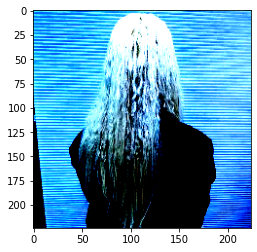

Label: 히피


In [ ]:
# Display image and label.
train_features, train_labels = next(iter(dataloader))
print(f"Feature batch shape: {train_features.size()}")

img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img)
plt.show()
print(f"Label: {label}")